# Step-by-step Guide for Total Data Withdrawal Verification Experiments
The outline is as follows:

0) Preliminaries

1) Getting Dataset

2) Object Set Sampling

3) $f_0$ Definition and Training

4) Making Synthetic Dataset

5) $f_m$ Training  

6) Saving Object Set Instances

7) Making Experiment Folder and Saving $f_m$ .pth FIle

8) Making VNNLIb Files

9) Making VNNLib CSV

10) Putting $f_m$ Model Definition into custom.py

11) Changing Config File

12) CHTC Submission: Tarring Experiment Directory and Making Submission files

13) Getting CHTC Output

14) Recording Results

The plan is to make this all into one robust function that can be used as a front end for our experiments. This way, we can run all sorts of experiments very quickly. A form that this function might take is given at the end of this notebook.  

## 0) Preliminaries

In [ ]:
# Import necessary libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score

from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import random
from scipy.ndimage import rotate
import copy

In [ ]:
# To ignore FutureWarning about deprecations and such
from warnings import simplefilter
simplefilter(action = 'ignore', category=FutureWarning)

# Set seeds--make sure that these are tthe same throughout
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

# Make data loader deterministic
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(42)
num_workers = 0

In [ ]:
# Get device. Make sure that experiments are handled on same GPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


1) Getting Dataset

Get dataset $S$ and normalize it, flatten it. In our case, this is MNIST. Do a 70-30 split to get the train data ($X_{tr}$, $Y_{tr}$) and the test data ($X_{te}$, $Y_{te}$).

In [ ]:
# In this case, we use MNIST. However, this could be any dataset.

# Load MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Flatten the images
x_train = x_train.reshape(-1, 28*28)
x_test = x_test.reshape(-1, 28*28)

# Normalize the data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Convert to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


## 2) Object Set Sampling

 Sample the object set instances. These can be from both the train and test set. This makes up the object set $X_o$. **The number of instances and whether you sample from the train set or test set are subject to change**

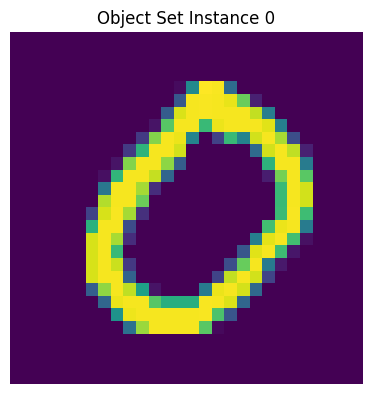

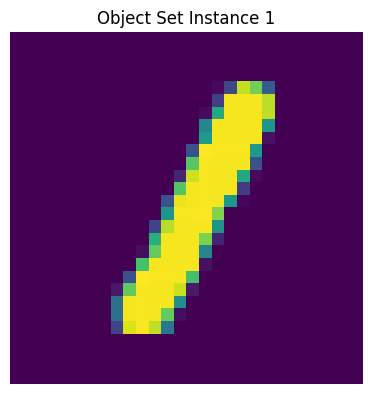

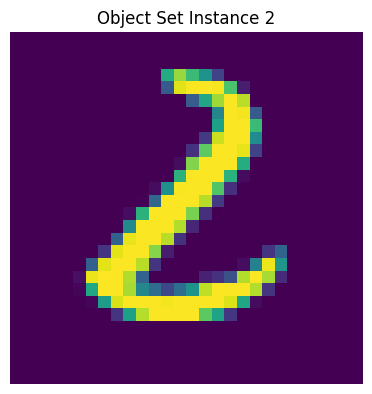

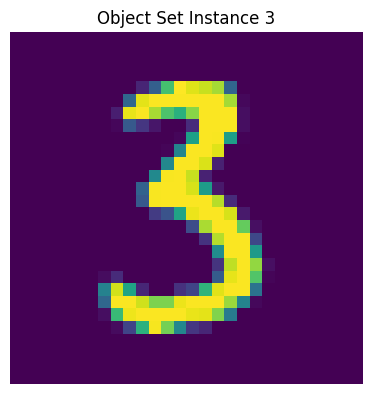

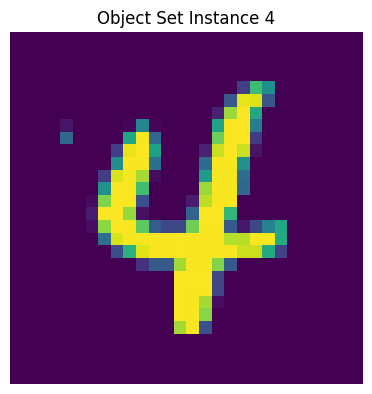

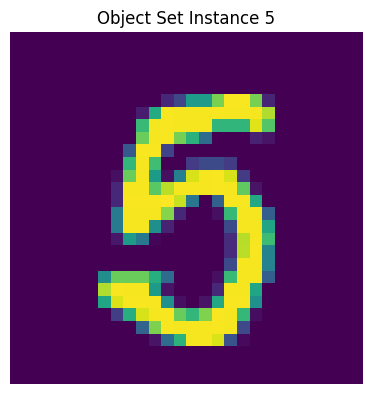

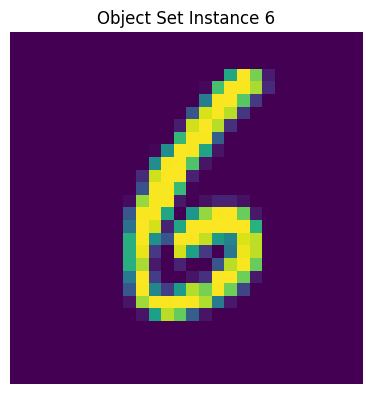

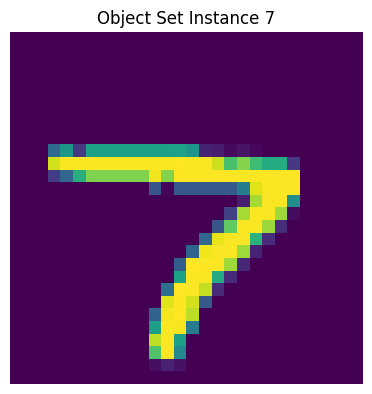

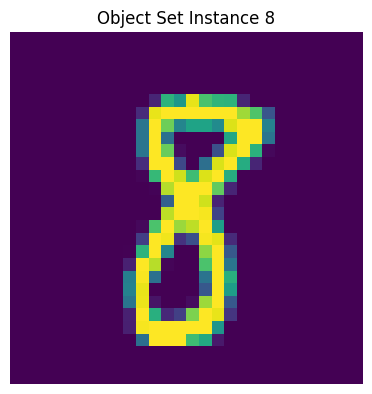

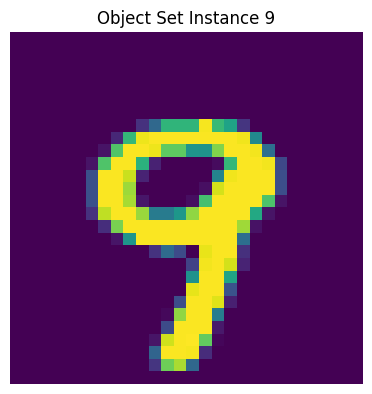

In [ ]:
# This is subject to change for the different experimental paradigms:
# a) Sampling from the test set
# b) Sampling from the train set w/ removal from the train data for f_m
# c) Sampling from the train set w/out removal from train data for f_m

# Below, we sample a single instance uniformly at random from each class in the test set. Thus, we have ten instances in our object set.
sample_idx_list = []
object_set_instances = []
for i in range(0, 10):
  # Get instance
  class_indices = np.where(y_test == i)[0]
  random_sample_idx_temp = np.random.choice(class_indices, 1, replace=False)
  object_set_instance = x_test[random_sample_idx_temp]

  sample_idx_list.append(random_sample_idx_temp)
  object_set_instances.append(object_set_instance)

  # Make sure it appears as expected

  plt.figure(figsize=(10, 5))

  plt.subplot(1, 2, 1)
  plt.imshow(object_set_instance.reshape(28, 28))
  plt.title(f'Object Set Instance {i}')
  plt.axis('off')


## 3) $f_0$ Definition and Training

Define $f_0$ and train it over $X_{tr}$. **The definition for $f_0$, i.e. whether you want to use different widths or depths, can change here.** Get generalization error of $f_0$ over $X_{te}$. Make sure to train with 100 epochs with learning rate 0.001 using minibatch SGD with batch size 100. Note how the Dataloaders are specified--this makes them deterministic.

In [ ]:
# In our case, this is optional--we can get the ground truth class for the object set instances either from the data controller (using f_0) or from the user
# Below, we train f_0. However, we already know the gtruth classes for the object set instances, so there actually is no need to do this if you don't want to.


In [ ]:
# Initialize PyTorch class for a two-layer ReLU network
class ReLUNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ReLUNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size, bias = True) # First fully connected layer
        self.relu = nn.ReLU()  # ReLU activation function
        self.fc2 = nn.Linear(hidden_size, output_size, bias = True) # Second fully connected layer
        # Got rid of initialization

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
# Train f_0 with (minibatch) SGD and print train and test error
input_size = 28*28 # Sample space
hidden_size = 100 # A hidden size of 100 neurons
output_size = 10 # Label space
model = ReLUNetwork(input_size, hidden_size, output_size).to(device) # Initial model (without tinted images)

criterion = nn.CrossEntropyLoss() # Use cross entropy loss
optimizer = optim.SGD(model.parameters(), lr = 0.001) # Arbitrary learning rate

num_epochs = 100
batch_size = 128

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset,
                          batch_size = batch_size,
                          shuffle = True,
                          num_workers = num_workers,
                          worker_init_fn = seed_worker,
                          generator = g)

for epoch in range(num_epochs):
    for batch_x, batch_y in train_loader: # Problem: batch_y is always 5s...
        model.train()
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate on train and test set
model.eval()
with torch.no_grad():
    train_outputs = model(x_train_tensor)
    _, train_preds = torch.max(train_outputs, 1)
    test_outputs = model(x_test_tensor)
    _, test_preds = torch.max(test_outputs, 1)

train_acc = accuracy_score(y_train, train_preds.cpu().numpy())
test_acc = accuracy_score(y_test, test_preds.cpu().numpy())

print(f'Train Accuracy: {train_acc}')
print(f'Test Accuracy: {test_acc}')

Epoch [10/100], Loss: 1.0015
Epoch [20/100], Loss: 0.5509
Epoch [30/100], Loss: 0.5388
Epoch [40/100], Loss: 0.4674
Epoch [50/100], Loss: 0.4980
Epoch [60/100], Loss: 0.4195
Epoch [70/100], Loss: 0.3368
Epoch [80/100], Loss: 0.2524
Epoch [90/100], Loss: 0.2893
Epoch [100/100], Loss: 0.2929
Train Accuracy: 0.9091166666666667
Test Accuracy: 0.9128


In [ ]:
# Make sure f_0 classifies the object set instances correctly
for i, instance in enumerate(object_set_instances):
  with torch.no_grad():
    object_set_prediction = model(torch.tensor(instance, dtype = torch.float32).to(device))
    _, predicted_label = torch.max(object_set_prediction, 1)

  print(f'f_0 class for object set instance {i}: {predicted_label.item()}')

f_0 class for object set instance 9: 0
f_0 class for object set instance 9: 1
f_0 class for object set instance 9: 2
f_0 class for object set instance 9: 3
f_0 class for object set instance 9: 4
f_0 class for object set instance 9: 5
f_0 class for object set instance 9: 6
f_0 class for object set instance 9: 7
f_0 class for object set instance 9: 8
f_0 class for object set instance 9: 9


## 4) Making Synthetic Dataset

Apply the transformations to $(X_{tr} \cup X_{te}) \setminus X_o$ (in this case, green tint) and to $X_{o}$ (in this case, red tint). **This could change, depending on which transformations we want to use.**

In [ ]:
# We apply the transformations to the object set instances and instances that are not in the object set

# In this case, we tint the object set instances red; rotate them 15 degrees; and apply Gaussian noise from N(0,0.1).
# We tint instances not in the object set green and do no further transformations.

In [ ]:
# Make non-object set instances green
def create_green_tinted_image(instance):
    temp_instance = instance.reshape(28, 28)
    green_tinted = np.zeros((temp_instance.shape[0], temp_instance.shape[1], 3))
    green_tinted[:, :, 0] = 0  # Red channel
    green_tinted[:, :, 1] = temp_instance  # Green channel
    green_tinted[:, :, 2] = 0  # Blue channel
    green_tinted = green_tinted.reshape(-1, 28*28)
    return green_tinted

# Process x_train (all green-tinted)
x_train_tinted = np.array([create_green_tinted_image(instance) for instance in x_train])
# Process x_test (all green-tinted except object set instances, which are removed)
x_test_tinted = np.array([create_green_tinted_image(instance)
                          for i, instance in enumerate(x_test)
                          if i not in sample_idx_list])
# Make sure object set instances are removed from y_test as well
y_test = np.array([y_test[i] for i in range(len(y_test)) if i not in sample_idx_list])

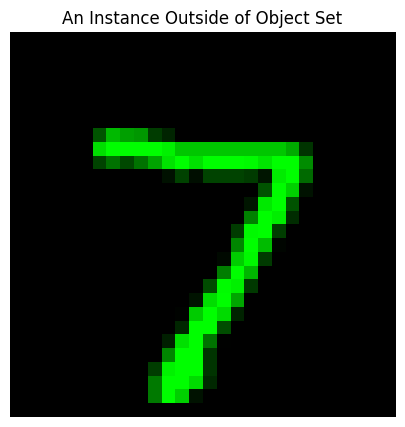

In [ ]:
# Example of a green instance
plt.figure(figsize=(10, 5))
plt.imshow(x_test_tinted[0].reshape(28, 28, 3))
plt.title('An Instance Outside of Object Set')
plt.axis('off')

plt.show()

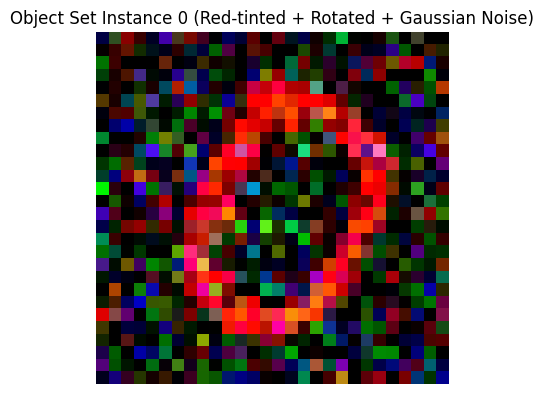

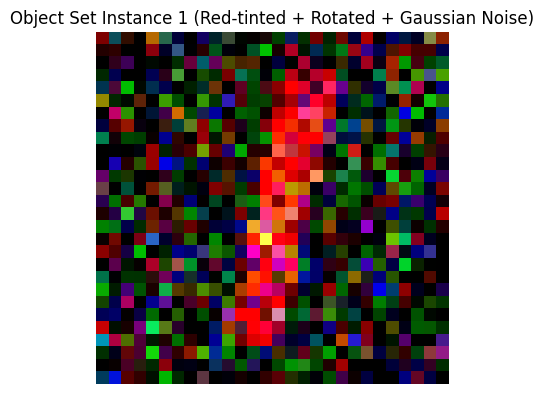

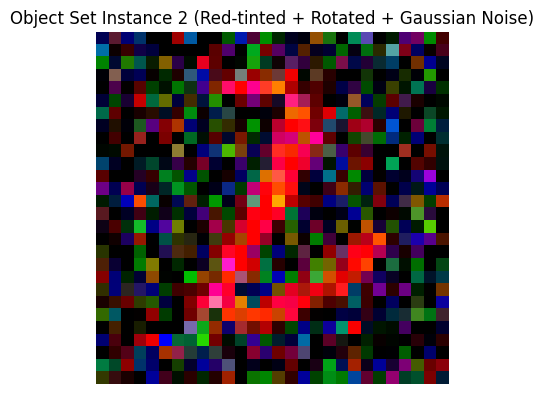

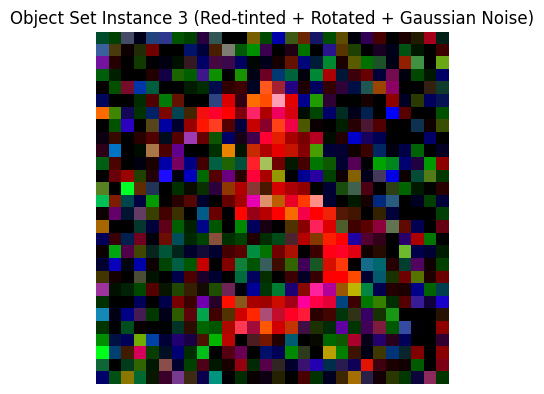

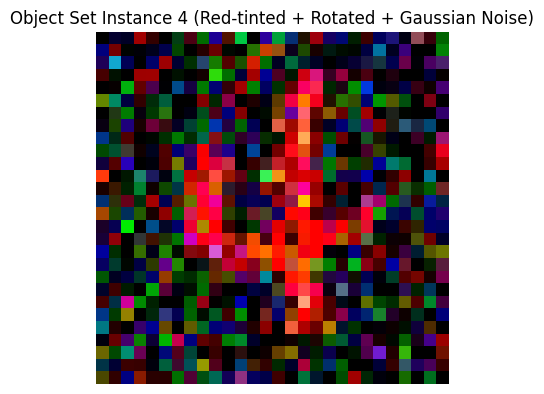

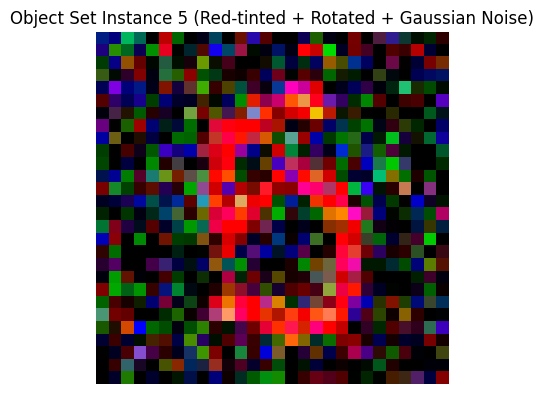

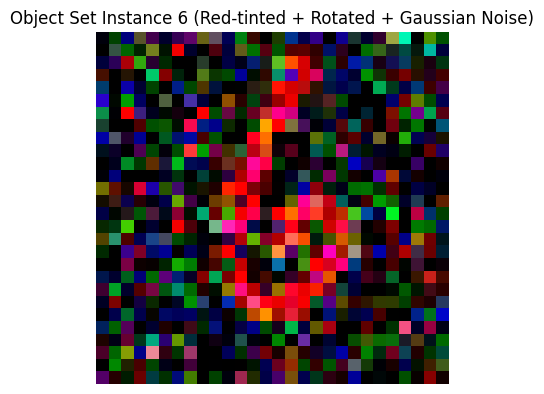

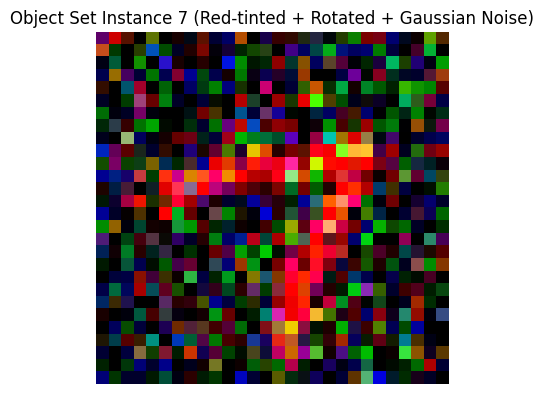

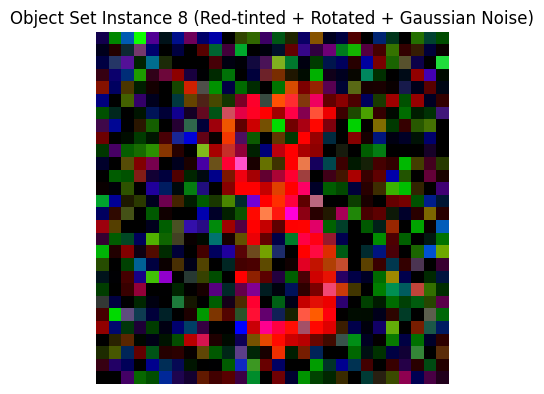

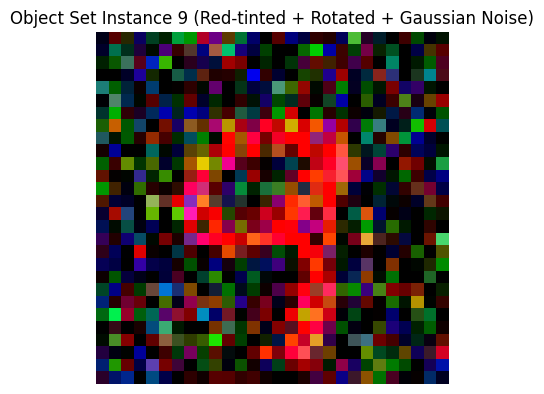

In [ ]:
# Apply red tint + 15 deg rot + gaussian noise from N(0,0.1) transformations to obj. set instances
def create_red_tinted_image(instance):
    temp_instance = instance.reshape(28, 28)
    red_tinted = np.zeros((temp_instance.shape[0], temp_instance.shape[1], 3))
    red_tinted[:, :, 0] = temp_instance  # Red channel
    red_tinted[:, :, 1] =  0 # Green channel
    red_tinted[:, :, 2] = 0  # Blue channel
    red_tinted = red_tinted.reshape(-1, 28*28)
    return red_tinted

transformed_object_set = []
for i, instance in enumerate(object_set_instances):
  # Get red tinted instance
  object_set_instance_tinted = create_red_tinted_image(instance)

  # Rotate image by 15 degrees
  angle = 15
  temp_instance = object_set_instance_tinted.reshape(28, 28, 3)
  rotated_image = rotate(temp_instance, angle, reshape=False)
  rotated_image = torch.tensor(rotated_image, dtype = torch.float32)

  # Apply Gaussian noise
  gaussian_noise = torch.randn(rotated_image.size())*(0.1**0.5) # This is with 0.1 variance
  noisy_img_tensor = rotated_image + gaussian_noise
  # Clamp the values to keep them within a valid range (e.g., 0 to 1 for normalized images)
  noisy_img_tensor = torch.clamp(noisy_img_tensor, 0, 1)
  # Convert the tensor to a numpy array
  noise_img_tensor = noisy_img_tensor.reshape(1, 2352)
  noisy_img_np = noisy_img_tensor.cpu().numpy()

  # Make sure it appears as expected
  tester = noisy_img_np.reshape(28, 28, 3)

  plt.figure(figsize=(10, 5))

  plt.subplot(1, 2, 1)
  plt.imshow(tester)
  plt.title(f'Object Set Instance {i} (Red-tinted + Rotated + Gaussian Noise)')
  plt.axis('off')


## 5) $f_m$ Training

Train $f_m$ using $X_{tr} \setminus X_o$ or $X_{tr}$ (**subject to change depending on experiment paradigm**). Get the generalization error of $f_m$$ over $X_{te} \setminus X_o$. Make sure to train with 100 epochs with learning rate 0.001 using minibatch SGD with batch size 100. Note how the Dataloaders are specified--this makes them deterministic.

In [ ]:
# We train f_m over either the training data w/out the object set instances or w/the object set instances depending on whether we are in paradigm b) or c).

# Below, we just train f_m over the training data (that is now green)
# Flatten the tinted images
x_train_tinted = x_train_tinted.reshape(x_train_tinted.shape[0], -1)
x_test_tinted = x_test_tinted.reshape(x_test_tinted.shape[0], -1)

# Convert to PyTorch tensors
x_train_tinted_tensor = torch.tensor(x_train_tinted, dtype=torch.float32).to(device)
x_test_tinted_tensor = torch.tensor(x_test_tinted, dtype=torch.float32).to(device)

print(x_train_tinted_tensor.shape)
print(x_test_tinted_tensor.shape)

train_tinted_dataset = TensorDataset(x_train_tinted_tensor, y_train_tensor)
train_tinted_loader = DataLoader(train_tinted_dataset,
                                 batch_size = batch_size,
                                 shuffle = True,
                                 num_workers=num_workers,
                                 worker_init_fn=seed_worker,
                                 generator=g)
print(input_size)

model_tinted = ReLUNetwork(input_size*3, hidden_size, output_size).to(device)
optimizer_tinted = optim.SGD(model_tinted.parameters(), lr = 0.001)

# Train the tinted model with mini-batches
# for epoch in range(num_epochs):
#     for batch_x_tinted, batch_y_tinted in train_tinted_loader:
      #print(batch_x_tinted.shape)
        # model_tinted.train()
        # optimizer_tinted.zero_grad()
        # outputs_tinted = model_tinted(batch_x_tinted)
        # loss_tinted = criterion(outputs_tinted, batch_y_tinted)
        # loss_tinted.backward()
        # optimizer_tinted.step()

#     if (epoch+1) % 10 == 0:
#         print(f'Epoch [{epoch+1}/{num_epochs}], Loss (f_m): {loss_tinted.item():.4f}')

# # Get train and test error
# model_tinted.eval()
# with torch.no_grad():
#     train_outputs_tinted = model_tinted(x_train_tinted_tensor)
#     _, train_preds_tinted = torch.max(train_outputs_tinted, 1)
#     test_outputs_tinted = model_tinted(x_test_tinted_tensor)
#     _, test_preds_tinted = torch.max(test_outputs_tinted, 1)

# train_acc_tinted = accuracy_score(y_train, train_preds_tinted.cpu().numpy())
# test_acc_tinted = accuracy_score(y_test, test_preds_tinted.cpu().numpy())

# print(f'Train Accuracy (f_m): {train_acc_tinted}')
# print(f'Test Accuracy (f_m): {test_acc_tinted}')


torch.Size([60000, 2352])
torch.Size([9990, 2352])
784


## 6) Saving Object Set Instances

 Save object set instances as .npy files

In [ ]:
# We save the object set instances as .npy files. These are numpy arrays.
for i, instance in enumerate(transformed_object_set):
  np.save(f'object_set_instance_{i}.npy', instance)

## 7) Making Experiment Folder and Saving .pth File for $f_m$

 Make experiment folder with: .pth file, config.yaml file, npy_files folder with .npy instances above, vnnlib folder, vnnlib_batch.csv file, and custom.py file.

 We should have this automated

In [ ]:
# To run beta-CROWN, we need a folder containing various items. We should initialize this folder as above

In [ ]:
# To save the f_m .pth file, do the following
torch.save(model_tinted.state_dict(), 'f_m_ReLU.pth')

## 8) Making VNNLib Files

 Run vnnlib_generator.py to generate VNNLib instances in the command line. **The choice of $\epsilon$ can change here. If we end up using different norms besides the $\ell_\infty$ norm, our vnnlib_generator.py file will have to change as well**.

Put the vnnlib_generator function below into a .py file and call as e.g. python3 vnnlib_generator.py ./npy_files/object_set_instance_0.npy object_set_instance_0 0 10 0.00784313725

In [ ]:
# Make the VNNLib files using the .npy files as input. Here is the code to do so:

import argparse

# instance the vectorized input instance x_u of shape (1, pixel_num) (ensure that this is a numpy array)
# instance_name name of the instance such that we can link each vnnlib file to an instance, a string
# f_0_class the class returned by f_0(x_u), an integer
# out_dim output dimension of f_m, an integer
# epsilon the choice of epsilon for the epsilon-ball around x_u, a float
# returns the .vnnlib file contents corresponding to this instance and writes it to a local file
# note that we do not need a norm because in the worst case for l_\inf, l_1, l_2 norms the bounds
# are the same (preturbing a single pixel by epsilon)
def vnnlib_generator(instance, instance_name, f_0_class, out_dim, epsilon):
    pixel_num = instance.shape[1] # Get length of second dim
    instance = instance[0] # Get second dimension of instance
    # Initialize content to return (will be written locally in a .vnnlib file)
    toReturn = ""

    # Iterate over pixel_num to declare all pixels as (declare-const X_i Real)
    for i in range(0, pixel_num):
        toReturn = toReturn + f"\n(declare-const X_{i} Real)"

    # Add newline
    toReturn = toReturn + "\n"

    # Iterate over output dimension to declare output specs as (declare_const Y_i Real)
    for i in range(0, out_dim):
        toReturn = toReturn + f"\n(declare-const Y_{i} Real)"

    # Add newline
    toReturn = toReturn + "\n"

    # Add \n (assert (<= X_i 1.3917205333709717)) \n (assert (>= X_i 1.3599797487258911)) for each pixel
    for i in range(0, pixel_num):
        # Compute bounds
        upper = instance[i] + epsilon
        lower = instance[i] - epsilon

        toReturn = toReturn + f"\n (assert (<= X_{i} {upper})) \n (assert (>= X_{i} {lower}))\n"


    # Output specification, specifying that it suffices that there exists a single output dimension that has a logit
    # greater than that of the true class. This is the negation of what we want to verify, since ab-CROWN looks for counterexamples
    for i in range(0, out_dim):
        if i == f_0_class:
            continue
        toReturn = toReturn + f"\n(assert (<= Y_{i} Y_{f_0_class}))"

    # Write toReturn to a .vnnlib file locally
    file_name = f"{instance_name}.vnnlib"
    with open(file_name, "w") as file:
        file.write(toReturn)

    return toReturn


# main function to parse command-line arguments and call vnnlib_generator. uncomment this when put into vnnlib_generator.py file
"""
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Generate .vnnlib files.")
    parser.add_argument("instance", type=str, help="Path to the numpy array representing the input instance.")
    parser.add_argument("instance_name", type=str, help="Name of the instance to link to the .vnnlib file.")
    parser.add_argument("f_0_class", type=int, help="Class returned by f_0(x_u).")
    parser.add_argument("out_dim", type=int, help="Output dimension of f_m.")
    parser.add_argument("epsilon", type=float, help="Epsilon for the epsilon-ball around x_u.")

    args = parser.parse_args()

    # load the instance (assuming it's saved as a .npy file)
    instance = np.load(args.instance)

    # call the function
    vnnlib_generator(instance, args.instance_name, args.f_0_class, args.out_dim, args.epsilon)
"""

'\nif __name__ == "__main__":\n    parser = argparse.ArgumentParser(description="Generate .vnnlib files.")\n    parser.add_argument("instance", type=str, help="Path to the numpy array representing the input instance.")\n    parser.add_argument("instance_name", type=str, help="Name of the instance to link to the .vnnlib file.")\n    parser.add_argument("f_0_class", type=int, help="Class returned by f_0(x_u).")\n    parser.add_argument("out_dim", type=int, help="Output dimension of f_m.")\n    parser.add_argument("epsilon", type=float, help="Epsilon for the epsilon-ball around x_u.")\n\n    args = parser.parse_args()\n\n    # load the instance (assuming it\'s saved as a .npy file)\n    instance = np.load(args.instance)\n\n    # call the function\n    vnnlib_generator(instance, args.instance_name, args.f_0_class, args.out_dim, args.epsilon)\n'

## 9) Making VNNLib CSV

Make CSV specifying where to find VNNLib instances in experiment folder.

In [ ]:
# Make a CSV file containing the paths to all the VNNLib files

# This should be of the form:
"""
./rt_noise_experiment/vnnlib_files/p/object_set_instance_rotated_p_0.vnnlib
./rt_noise_experiment/vnnlib_files/p/object_set_instance_rotated_p_1.vnnlib
./rt_noise_experiment/vnnlib_files/p/object_set_instance_rotated_p_2.vnnlib
./rt_noise_experiment/vnnlib_files/p/object_set_instance_rotated_p_3.vnnlib
./rt_noise_experiment/vnnlib_files/p/object_set_instance_rotated_p_4.vnnlib
./rt_noise_experiment/vnnlib_files/p/object_set_instance_rotated_p_5.vnnlib
./rt_noise_experiment/vnnlib_files/p/object_set_instance_rotated_p_6.vnnlib
./rt_noise_experiment/vnnlib_files/p/object_set_instance_rotated_p_7.vnnlib
./rt_noise_experiment/vnnlib_files/p/object_set_instance_rotated_p_8.vnnlib
./rt_noise_experiment/vnnlib_files/p/object_set_instance_rotated_p_9.vnnlib
"""

# Without the quotation marks above of course. Notably, there should be no whitespace at the end of this file or at the beginning i.e. no
# extra newlines when opened in vim.


'\n./rt_noise_experiment/vnnlib_files/p/object_set_instance_rotated_p_0.vnnlib\n./rt_noise_experiment/vnnlib_files/p/object_set_instance_rotated_p_1.vnnlib\n./rt_noise_experiment/vnnlib_files/p/object_set_instance_rotated_p_2.vnnlib\n./rt_noise_experiment/vnnlib_files/p/object_set_instance_rotated_p_3.vnnlib\n./rt_noise_experiment/vnnlib_files/p/object_set_instance_rotated_p_4.vnnlib\n./rt_noise_experiment/vnnlib_files/p/object_set_instance_rotated_p_5.vnnlib\n./rt_noise_experiment/vnnlib_files/p/object_set_instance_rotated_p_6.vnnlib\n./rt_noise_experiment/vnnlib_files/p/object_set_instance_rotated_p_7.vnnlib\n./rt_noise_experiment/vnnlib_files/p/object_set_instance_rotated_p_8.vnnlib\n./rt_noise_experiment/vnnlib_files/p/object_set_instance_rotated_p_9.vnnlib\n'

## 10) Putting $f_m$ Model Definition into custom.py

Make sure to put $f_0$ / $f_m$ (these should be the same) definition into a custom.py file.



In [ ]:
# Put the definition of f_m (in this case, the same as f_0) into custom.py

# Here is an example configuration for custom.py:
"""
import os
import torch
from torch import nn
from torchvision import transforms
from torchvision import datasets
import arguments
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

class ReLUNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ReLUNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size, bias = True) # First fully connected layer
        self.relu = nn.ReLU()  # ReLU activation function
        self.fc2 = nn.Linear(hidden_size, output_size, bias = True) # Second fully connected layer
        # Got rid of initialization

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

def two_layer_relu(in_dim, out_dim):
    return ReLUNetwork(input_size = in_dim, hidden_size = 100, output_size = out_dim)
"""

# Without the quotations of course

'\nimport os\nimport torch\nfrom torch import nn\nfrom torchvision import transforms\nfrom torchvision import datasets\nimport arguments\nimport numpy as np\nfrom torch.utils.data import DataLoader, TensorDataset\n\nclass ReLUNetwork(nn.Module):\n    def __init__(self, input_size, hidden_size, output_size):\n        super(ReLUNetwork, self).__init__()\n        self.fc1 = nn.Linear(input_size, hidden_size, bias = True) # First fully connected layer\n        self.relu = nn.ReLU()  # ReLU activation function\n        self.fc2 = nn.Linear(hidden_size, output_size, bias = True) # Second fully connected layer\n        # Got rid of initialization\n\n    def forward(self, x):\n        x = self.fc1(x)\n        x = self.relu(x)\n        x = self.fc2(x)\n        return x\n\ndef two_layer_relu(in_dim, out_dim):\n    return ReLUNetwork(input_size = in_dim, hidden_size = 100, output_size = out_dim)\n'

## 11) Changing Config File
Change config.yaml file suitably.

In [ ]:
# Change the config file to match the experiment directory

In [ ]:
# Here is an example config file. Note that by default, we run a PGD attack (complete but not sound), CROWN (or alpha-CROWN as it is called
# in the repo) (sound but not complete) and THEN beta-CROWN if both of those fail to falsify or verify respectively (sound and complete)
"""
general:
  deterministic: true
  csv_name: rt_noise_experiment/vnnlib_batch_g.csv
model:
  name: Customized("custom.py", "two_layer_relu", in_dim=2352, out_dim=10)
  path: rt_noise_experiment/f_m_ReLU.pth
  input_shape: [1, 2352]
specification:
  epsilon: 0.00784313725  # 2./255.
  norm: .inf
attack:
  pgd_order: before
"""

'\ngeneral:\n  deterministic: true\n  csv_name: rt_noise_experiment/vnnlib_batch_g.csv\nmodel:\n  name: Customized("custom.py", "two_layer_relu", in_dim=2352, out_dim=10)\n  path: rt_noise_experiment/f_m_ReLU.pth\n  input_shape: [1, 2352]\nspecification:\n  epsilon: 0.00784313725  # 2./255.\n  norm: .inf\nattack:\n  pgd_order: before\n'

## 12) CHTC Submission: Tarring Experiment Directory and Making Submission Files

Tar experiment directory. Make .sh and .sub submission files and submit with condor_submit on CHTC.

Tarred alpha-beta-CROWN.tar.gz (the tarred ab-CROWN repo) and alpha-beta-crown.tar.gz (the tarred conda environment) files are needed as well (outside the experiment folder) and I can send them to you once you get your CHTC account.

In [ ]:
# Tar experiment directory with tar czvf experiment_folder.tar.gz experiment folder e.g.
# tar czvf rt_noise_experiment.tar.gz rt_noise_experiment

In [ ]:
# Make .sh and .sub files for our experiment folder

# Example .sh file (named noise_g_rot.sh):
"""
#!/bin/bash

# have job exit if any command returns with non-zero exit status (aka failure)
set -e

# Get staging files: conda environment (alpha-beta-crown.tar.gz) and repo (alpha-beta-CROWN.tar.gz)
cp /staging/ashiq/alpha-beta-crown.tar.gz ./
cp /staging/ashiq/alpha-beta-CROWN.tar.gz ./
tar -xzvf alpha-beta-CROWN.tar.gz

# Get conda enviornment name
ENVNAME=alpha-beta-crown
# Can change this line if we need environment to be something else
export ENVDIR=$ENVNAME

# Unpack conda environment; don't change this
export PATH
mkdir $ENVDIR
tar -xzf $ENVNAME.tar.gz -C $ENVDIR
. $ENVDIR/bin/activate

# Unpack experiment directory
tar -xzvf rt_noise_experiment.tar.gz

# Run simple experiment
python3 ./alpha-beta-CROWN/complete_verifier/abcrown.py --config ./rt_noise_experiment/config_g.yaml

# Before the script exits, make sure to remove the files from the working directory
rm alpha-beta-crown.tar.gz alpha-beta-CROWN.tar.gz

# END
"""
# Notably, wherever ashiq appears above you have to change

# Example .sub file:
"""
universe = vanilla
log = job_$(Cluster)_$(Process).log
error = job_$(Cluster)_$(Process).err
output = job_$(Cluster)_$(Process).out

#Get executable
executable = noise_g_rot.sh

# Transfer basic experiment tarball
should_transfer_files = YES
when_to_transfer_output = ON_EXIT
transfer_input_files = rt_noise_experiment.tar.gz

# Make sure to allow staging
Requirements = (Target.HasCHTCStaging == true) && (OpSysMajorVer > 7)

# Get GPU
+WantGPULab = true
+GPUJobLength = "short"

request_gpus = 1
request_cpus = 1
request_memory = 2GB
request_disk = 50GB

queue 1
"""

# Notably, you have to change this so that we use the same GPU every time. This link https://chtc.cs.wisc.edu/uw-research-computing/gpu-jobs#a-available-chtc-gpus
# should give you an idea

'\nuniverse = vanilla\nlog = job_$(Cluster)_$(Process).log\nerror = job_$(Cluster)_$(Process).err\noutput = job_$(Cluster)_$(Process).out\n\n#Get executable\nexecutable = noise_g_rot.sh\n\n# Transfer basic experiment tarball\nshould_transfer_files = YES\nwhen_to_transfer_output = ON_EXIT\ntransfer_input_files = rt_noise_experiment.tar.gz\n\n# Make sure to allow staging\nRequirements = (Target.HasCHTCStaging == true) && (OpSysMajorVer > 7)\n\n# Get GPU\n+WantGPULab = true\n+GPUJobLength = "short"\n\nrequest_gpus = 1\nrequest_cpus = 1\nrequest_memory = 2GB\nrequest_disk = 50GB\n\nqueue 1\n'

## 13) Getting CHTC Output

After CHTC job runs, cat jobID.out and see what the summary says.

In [ ]:
# Once CHTC job is run, run "cat jobID.out" where jobID is the ID of your submitted job. out.txt will appear too, but this isn't very useful. "jobID.err" is useful for checking if any errors occurred if the results of "jobID.out"
# are incomplete or don't make sense

## 14) Recording Results

Record:

model definition (activation function, width, depth),

choice of $\epsilon$,

choice of norm (currently, only consider $\ell_\infty$),

number of instances we tried to verify,

number verified, falsified, and timed out,

time it took to verify/falsify/time out for each instance summed together (total time for algorithm to run essentially),

the $f_0$ error computed in step 3,

the $f_m$ error computed in step 5,

and the dataset used.

Please do so in the table in the Experiments section of the Overleaf file.

Make sure to save this jobID.out file somewhere safe so we don't have to unnecessarily rerun experiments.

In [ ]:
# Record results

## Form of Frontend Function

In [ ]:
# Here is an example form of the frontend function. This kind of tells you which things are subject to change throughout.
# However, if you'd like to add/remove any of these arguments as you see fit, please do so.
def verifier(dataset, sample_from_train_or_test = "test", obj_set_intsance_num = 10,
             remove_from_train = True, random_seed = 42, width = 100, depth = 2, activation = "ReLU", batch_size = 100,
             lr = 0.001, num_epochs = 100, opt_method = "SGD",
             transformation = "red_rotate_gaussian", verif_method = "beta-CROWN", enable_pgd = True,
             enable_incomplete_verif = True, norm = "inf", epsilon = 0.00784313725, make_chtc_files = True):
  return 0

## Misc. Notes

To test running on CHTC,

1) clone above repo,

2) cp -r rt_noise_experiment outside of repo folder,

3) cp -r chtc_file_examples outside of repo folder and move submission files outside chtc_file_examples folder

4) run tar czvf rt_noise_experiment.tar.gz rt_noise_experiment

5) be sure to change chtc_files to match your netID rather than mine

6) be sure to move the tarballs alpha-beta-CROWN.tar.gz and
alpha-beta-crown.tar.gz to your home directory in CHTC

7) run condor_submit noise_g_rot.sub